# Linguagem Natural parte 1: Introdução ao NLP com análise de sentimento

Material referente ao curso da Alura disponível [aqui](https://cursos.alura.com.br/course/introducao-a-nlp-com-analise-de-sentimento).

## Informações sobre a aula:

1. O Dataset textual não pode ser diretamente classificado por um classificador como o `LogisticRegression`, visto que não está ainda 'traduzido' para a linguagem de máquina e essa é a função do NLP.

## Preparando o ambiente

In [43]:
!pip install wordcloud

In [44]:
%matplotlib inline

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

In [8]:
SEED = 42

## Carregando os dados

In [2]:
resenha = pd.read_csv('dados/imdb-reviews-pt-br.csv')
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


## Preparando os dados

In [6]:
X = resenha.text_pt
y = resenha.sentiment

In [12]:
resenha['classificacao'] = resenha['sentiment'].replace(['neg', 'pos'], [0, 1])
resenha.head()

,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


### Bag of Words

### Exemplo de uso do `CountVectorizer`:

In [17]:
texto = ['Assisti um filme ótimo', "Assisti um filme ruim"]

vetorizar = CountVectorizer()
bag_of_words = vetorizar.fit_transform(texto)
bag_of_words

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [23]:
columns = vetorizar.get_feature_names()
columns

['assisti', 'filme', 'ruim', 'um', 'ótimo']

O retorno de `CountVectorizer.fit_transform()` é uma _matriz esparsa_, ou seja, uma matriz que é otimizada para não armazenar os valores vazios, mas apenas os preenchidos. Dessa forma, ela não pode ser diretamente usada em um DataFrame.

In [25]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=columns)
matriz_esparsa

,assisti,filme,ruim,um,ótimo
0,1,1,0,1,1
1,1,1,1,1,0


### Criando o _bag of words_ para o modelo real

Para reduzir o custo computacional existe o parâmetro `max_features` para o `CountVectorizer`. Ele cria os vetores apenas com as N palavras mais usadas.

In [33]:
vetorizar = CountVectorizer(max_features=100)
bag_of_words = vetorizar.fit_transform(X)
feature_names = vetorizar.get_feature_names()
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=feature_names)
matriz_esparsa.head()

,ainda,algumas,alguns,anos,ao,apenas,as,assistir,até,bem,...,todos,tudo,tão,um,uma,ver,vez,vi,vida,você
0,0,0,0,0,1,0,0,0,1,1,...,0,1,0,3,2,0,1,0,0,0
1,1,0,0,0,0,0,0,3,0,2,...,1,0,0,5,2,4,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,2,1,3,2,0,1,0,0,2
3,1,0,0,1,0,1,4,0,2,1,...,2,0,0,7,4,1,0,1,0,1
4,0,1,0,0,0,1,2,1,0,1,...,0,0,0,3,4,0,0,0,0,0


## Realizando a classificação com `LogisticRegression`

In [34]:
X_train, X_test, y_train, y_test = train_test_split(matriz_esparsa, y, stratify=y, random_state=SEED)

In [35]:
regressao_logistica = LogisticRegression()
regressao_logistica.fit(X_train, y_train)
acuracia = regressao_logistica.score(X_test, y_test)
print(acuracia)

0.7063485644965629


Note que o score não foi muito alto. Um dos problemas está em que as palavras mais usadas são palavras com pouco valor dentro do texto (_stop words_).

É interessante também registrar que para `max_features=50` a acurácia foi de 66% e para `max_features=100` foi 70%. Isso reforça a tese do problema das _stop words_.

In [41]:
def classificar_texto(X, y, max_features=100, seed=42):
    tempo_inicial = time.time()
    vetorizar = CountVectorizer(max_features=max_features)
    bag_of_words = vetorizar.fit_transform(X)
    feature_names = vetorizar.get_feature_names()
    matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=feature_names)
    matriz_esparsa.head()
    X_train, X_test, y_train, y_test = train_test_split(matriz_esparsa, y, stratify=y, random_state=seed)
    regressao_logistica = LogisticRegression()
    regressao_logistica.fit(X_train, y_train)
    acuracia = regressao_logistica.score(X_test, y_test)
    print(f'Acurácia: {acuracia}')
    print(f"Tempo de Execução: {time.time() - tempo_inicial} segundos")
    return acuracia

In [42]:
classificar_texto(X, y)

Acurácia: 0.7063485644965629
Tempo de Execução: 21.364996671676636 segundos


0.7063485644965629

## WordCloud

### Nuvem de todas as palavras

In [68]:
def criar_nuvem(X):
    todas_palavras = ' '.join([texto for texto in X])
    nuvem_palavras = WordCloud(background_color="white", max_words=1000, width=800, height=500, max_font_size=110, collocations=False).generate(todas_palavras)
    plt.figure(figsize=(16,9))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.show();

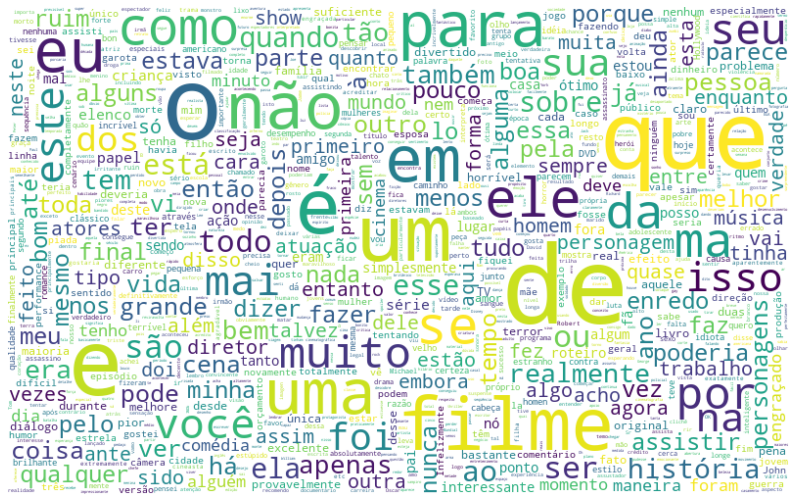

In [69]:
criar_nuvem(X)

### Palavras positivas

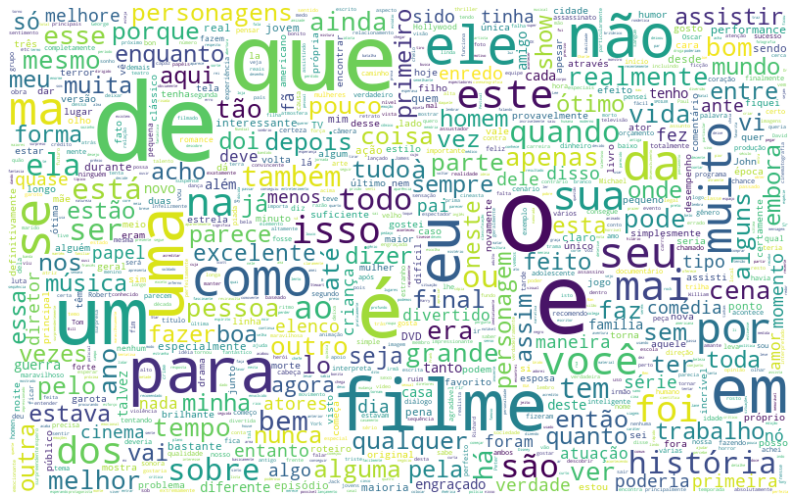

In [70]:
criar_nuvem(resenha.query("sentiment == 'pos'")['text_pt'])

### Palavras negativas

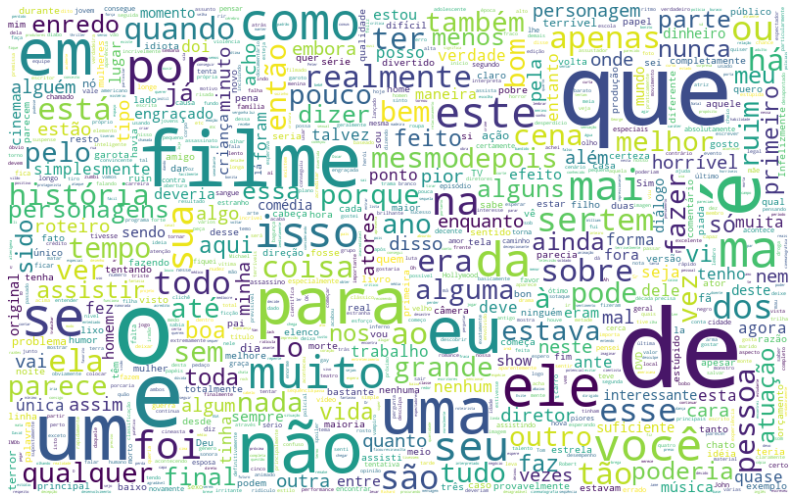

In [71]:
criar_nuvem(resenha.query("sentiment == 'neg'")['text_pt'])